# Path Planning and Controller Design for USVs
This Jupyter notebook describe path planning and controller design for the USV made by Marine Thinking Inc. In this notebook, boat and the controller are python classes, this means that for example the boat is an object with some attributes and functions such as length attribute or driving function. The following sections are provided for this goal.

## Table of Content

* [Loading dependency packages](#package)
* [Controller design](#control)
* [Boat modelling](#boat)
* [Simulation of the boat movement](#simulation)
* [Path planning](#path)
* [Test data cleaning and analysis](#data)

## Loading dependency packages <a class="anchor" id="package"></a>


All required packages are downloaded and imported in the next section. The commands starting with ! run a code in the terminal instead of python.

In [1]:
## the following line load numeric and scientific packages
from scipy import integrate, misc
import numpy as np
from numpy import matmul, diag, array, meshgrid, ones, zeros
from numpy.random import rand
from scipy.spatial.transform import Rotation as R

## these two lines are for installing simpy package for real time environment
!pip install simpy
import simpy

## the following lines are for importing visualization and animation packages
import scipy.ndimage as ndimage
from matplotlib import animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import ffmpy

## the following lines are for importing data analysis packages
import pandas as pd

## Controller design <a class="anchor" id="control"></a>
We use the real-time environment `simpy` in the python to enable us to apply control input to the boat in the real time. Every controller is an object of the controller class with 
        
      attributes: 
              
**real_time_environment**: a `simpy` environment object

**feedback law**: a function that gets the states and returns control inputs
        
      methods:

**get_state(boat)**: a function that gest the sate of a boat

**find_input(boat)**: a function that calculates the input to a boat


In [5]:
class controller:
    def __init__(self, feedback_law, real_time_environment=False):
        self.env = real_time_environment
        self.law = feedback_law

    def get_state(self, boat):
        return boat.state
        
    def find_input(self, boat):
        feedback_law = self.law
        control_input = feedback_law(boat.state)
        return control_input

## Boat modelling <a class="anchor" id="boat"></a>
In this section, a software model of the boat is developed to interact with the controller. The boat model is described in [this](./pdfs/HovercraftModel.pdf) pdf file. Similarly, a `simpy` environment is created for real-time interaction with the controller. A **boat** class is created; an object of this class will have all the futures and functionality of the boat including:

    attributes:

**real_time_environment**: a `simpy` environment object

**state**: state of the boat is initialized using a python dictionary containing initial coordinate and velocities with this convection: `initial_state={'x0':0, 'y0':0, 'psi0':0,'u0':, 'v0':0, 'r0':0}`. After driving the boat, each state is a numpy array with 7 columns, the first 6 columns refer to the boat state ordered as in the initial state, and the 7th columns is time. That is, `state=np.array([[x, y, psi, u, v, r, time], ...])`.

**x, y, psi, u, v, r, time**: after driving the boat each of these attributes are stored in a boat as a numpy sequence.

**parameters**: parameters of the boat such as `length` and `time_increment`: This is initialized using a python dictionary with this convection: `parameters={'length':1, 'time_increment':0.1}`. 

    methods:

**drive(controller, time)**: This method drives the boat under a **controller** object for the duration of **time**.

**animate(path, realtime=True)**: This method creates an animation of the boat simulation and stores it in the **path** directory.

In [10]:
class boat():    
    
    def __init__(self, real_time_environment=False, initial_state={'x0':0, 'y0':0, 'psi0':0,'u0':0, 'v0':0, \
        'r0':0}, parameters={'boat length':1, 'time_increment':0.1}):
        self.env = real_time_environment
        self.length = parameters['boat length'] 
        self.time_increment = parameters['time_increment']
        self.state = list(initial_state.values()) + [0]
    
    def drive(self, controller, time):
        feedback_law = controller.law
        
        def Dstate_Dt(state, t, feedback_law):
            x, y, psi, u, v, r = state
            Tu, Tr, Tf = feedback_law(t)
            
            Du = Tu + v*r
            Dv = -u*r   
            Dr = Tr 
            Dx = u
            Dy = v
            Dpsi = r

            Dstate_Dt = [Du, Dv, Dr, Dx, Dy, Dpsi] 
            return Dstate_Dt
        
        if self.env:
            while self.env.now < time:
                timeframe = [self.env.now, self.env.now + self.time_increment]
                sol = integrate.odeint(Dstate_Dt, self.state[:-1], timeframe, args=(feedback_law,))
                self.env.timeout(self.env.now + self.time_increment)
                self.state.append([sol[1, 0], sol[1, 1], sol[1, 2], sol[1, 3], sol[1, 4], sol[1, 5], self.env.now])
        else:
            t = np.arange(0, time, self.time_increment)
            sol = integrate.odeint(Dstate_Dt, self.state[:-1], t, args=(feedback_law,))
            self.state = sol
            self.x = sol[:,0]
            self.y = sol[:,1]
            self.psi = sol[:,2]
            self.u = sol[:,3]
            self.v = sol[:,4]
            self.r = sol[:,5]
            self.time = t

            
    
    def animate(self, FileName):
        fig = plt.figure()
        im = plt.imread('boat2.png')
        y_min, y_max = [-10, 10]
        x_min, x_max = [-10, 10]
        ax = plt.axes(xlim=(x_min,x_max), ylim=(y_min,y_max))
        time=ax.annotate('$time=$0',xy=(-9, 9))
        line, = ax.plot([], [], lw=2)

        plt.xlabel('$x$')
        plt.ylabel('$y$')

        plotcols = ["blue" , "red", "red"]
        plotlabels = ["Center" , "Front", "End"]
        plotlws = [3, 1, 1] 
        plotmarkers = ['o','*','.']
        lines = []
        
        for index in range(3):
            lobj = ax.plot([],[], 's', lw=plotlws[index], marker=plotmarkers[index], color=plotcols[index], label=plotlabels[index])[0]
            #ax.legend()
            lines.append(lobj)

        def init():
            for line in lines:
                line.set_data([],[])
            return lines

        global ann
        ann = []
        def animated(i,dt):
            global ann
            if ann:
                ann.remove()
            #for artist in plt.gca().lines + plt.gca().collections:
            #    artist.remove()
            
            L = self.length

            def rotate_image(path, degree):
                img = plt.imread(path)
                img = ndimage.rotate(img, degree)
                return OffsetImage(img, zoom=0.2)
            
            ann = AnnotationBbox(rotate_image('boat2.png', self.psi[i]*180/np.pi), (self.x[i], self.y[i]), frameon=False)
            ax.add_artist(ann)
            #ax.axis('off')
            #ann_list.append(ann)
            
            #newax = fig.add_axes([0, 0, L/10, L/10], anchor='C')
            #img_boat_rotated = ndimage.rotate(im, self.psi[i]*180/np.pi)
            #img_boat_rotated_shifted = ndimage.shift(img_boat_rotated, [self.x[i], self.y[i], 0])
            #newax.imshow(img_boat_rotated_shifted)
            #newax.axis('off')
        
            #xlist = [self.x[i], self.x[i]+L*np.cos(self.psi[i]), self.x[i]-L*np.cos(self.psi[i])]
            #ylist = [self.y[i], self.y[i]+L*np.sin(self.psi[i]), self.y[i]-L*np.sin(self.psi[i])]
            s=i*dt
            time.set_text('$time=$%2.1f'%s)
            #for lnum, line in enumerate(lines):
            #    line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 
            #return lines

        path_mp4 = './mp4s/' + FileName + '.mp4'
        path_gif = './gifs/' + FileName + '.gif'

        dt = self.time[1]-self.time[0]
        t_max = self.time[-1]
        
        anim = animation.FuncAnimation(fig,lambda i: animated(i,dt), init_func=init,frames=int(t_max/dt), interval=0.1, blit=False)
        anim.save(path_mp4, fps=10, extra_args=['-vcodec', 'libx264'])
        ff = ffmpy.FFmpeg(inputs = {path_mp4:None} , outputs = {path_gif: None})
        ff.run()
        
        if self.env:
            anim.show()

## Simulation of the boat movement <a class="anchor" id="simulation"></a>

In this section, we run the last two modules and simulate the boat movement. The animation results are stores as gif file in the gif directory.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

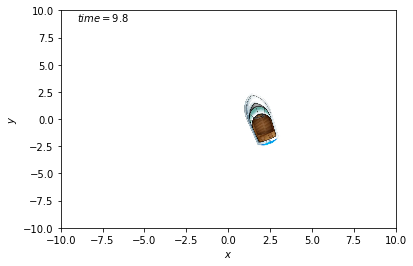

In [11]:
## Sinusoidal input
def control_law(t):
    return [np.sin(t), np.sin(t), 0]

## Fixed input for two forward trusters as in Haris Beta boat 
#T1 = 100
#T2 = 80
#def control_law(t):
#    return [T1+T2, abs(T1-T2), 0]

real_time_environment = False

if real_time_environment:
    env = simpy.Environment()
    mycontroller = controller(env, control_law)
    myboat = boat(env)
    time = 10
    env.process(myboat.drive(mycontroller, time))
    env.run(until=time)
else:
    mycontroller = controller(control_law)
    myboat = boat()
    myboat.drive(mycontroller, 10)
    #print("This is the boat state over time:", myboat.state)
    myboat.animate("animation26")

## Path Planning <a class="anchor" id="path"></a>

In this section, path planning for the USV in the presence of obstacles is investigated. For a review of path planning methods, please refer to the literature review and presentation file in Haris Beta research repository (linked to sprint 19). Here we apply relaxed A* algorithm developed by Ammar 2015 in [this](./pdfs/Ammar-2015-relaxedAstar.pdf) pdf file.

The path planning module consist of a grid map, vertices, and obstacles. Vertices are points on the grid map. Each vertices belong to the `vertex class`. This vertex class has methods and attributes as follows:

`attributes`:

**x**: the horizontal position

**y**: the vertical position

**g_score**: the exact cost from starting node (g score) in the relaxed A* algorithm

**f_score**: the heuristic cost to the goal (f score) in the relaxed A* algorithm

**obstacle**: it is 1 if the vertex is an obstacle; otherwise, 0.

`methods`:

**set_g_score(value)**: sets the g_score to the value

**set_f_score(value)**: sets the f_score to the value

**heuristic_cost(goal)**: calculates the heuristic cost to the goal

**isObstacle()**: it is 1 if vertex is an obstacle

**find_neighbors(grid)**: returns a list of valid non-obstacle neighbors of a vertex in the grid

**reconstruct_path(grid)** once the algorithm is run over a grid; use this function to return a list of vertices from start to goal consisting of the optimal path.

**plot_grid(grid, show_g_score=0)** use this function to plot the grid, set **show_g_score** to 1 to include g scores in the plot.

**plot_path(paht, grid)** use this function after plotting the grid to plot the optimal path.

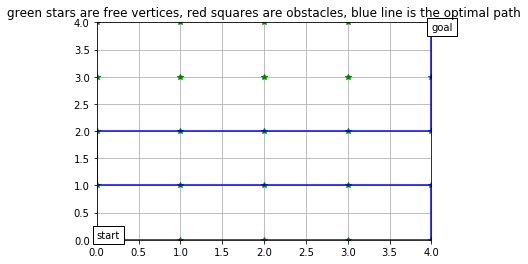

In [13]:
grid_length = 4
grid_width = 4

class vertex:
    def __init__(self, x, y, g_score=np.inf, f_score=np.inf, obstacle=0):
        self.x = x
        self.y = y
        self.g_score = g_score
        self.f_score = f_score
        self.obstacle = obstacle

    def set_g_score(self, value):
        self.g_score = value

    def set_f_score(self, value):
        self.f_score = value

    def heuristic_cost(self, other):
        cost = np.sqrt((self.x-other.x)**2+(self.y-other.y)**2)
        return cost

    def isObstacle(self):
        return self.obstacle

    def find_neighbors(self, grid):
        x = self.x
        y = self.y
        neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        valid_neighbors = []
    
        for neighbor in neighbors:
            if neighbor[0] <= grid_length and neighbor[0] >= 0 and neighbor[1] <= grid_width and neighbor[1] >= 0:
                if not grid[neighbor[0]][neighbor[1]].isObstacle():
                    valid_neighbors.append(neighbor)
        
        return valid_neighbors
    
    def plot_grid(self, start, goal, grid, show_g_score=0):
        plt.xlim([0, grid_length])
        plt.ylim([0, grid_width])
        plt.title('green stars are free vertices, red squares are obstacles, blue line is the optimal path')
        plt.grid()
        plt.text(start.x, start.y, 'start', bbox=dict(facecolor='white'), verticalalignment='bottom')
        plt.text(goal.x, goal.y, 'goal', bbox=dict(facecolor='white'), verticalalignment='top')
        for rows in grid:
            for vertices in rows:
                if vertices.obstacle:
                    plt.plot(vertices.x, vertices.y, 'sr')
                else:
                    plt.plot(vertices.x, vertices.y, '*g')
                    if show_g_score:
                        plt.title('g scores are indicated in the box.')
                        plt.text(vertices.x, vertices.y, round(vertices.g_score, 1), bbox=dict(facecolor='white'), verticalalignment='top')
    
    def reconstruct_path(self, goal, grid):
        path = [(self.x, self.y)]
        next = self
        while next != goal:
            neighbors = next.find_neighbors(grid)
            good_neighbors = []
            for neighbor in neighbors:
                if neighbor not in path:
                    good_neighbors.append(neighbor)
                if neighbor == (goal.x, goal.y):
                    path.append(neighbor)
                    return path
            g_score_list = [grid[index[0]][index[1]].g_score for index in good_neighbors]
            gscore_min = min(g_score_list)
            id = g_score_list.index(gscore_min)
            next = grid[good_neighbors[id][0]][good_neighbors[id][1]]
            path.append((next.x, next.y))
        return path
    
    def plot_path(self, path, grid):
        for i in range(len(path)-1):
            plt.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'b')




grid = []
for i in range(grid_length+1):
    row = []
    for j in range(grid_width+1):
        row.append(vertex(i,j))
    grid.append(row)

start = grid[0][0]
goal = grid[-1][-1]

tBreak = 1 + 1/(grid_length + grid_width)

openSet = set([(start.x, start.y)])

start.set_g_score(0)
start.set_f_score(start.heuristic_cost(goal))

while openSet and goal.g_score == np.inf:
    index_list = list(openSet)
    f_score_list = [grid[index[0]][index[1]].f_score for index in index_list]
    fscore_min = min(f_score_list)
    id = f_score_list.index(fscore_min)
    current = grid[index_list[id][0]][index_list[id][1]]

    #print(index_list, f_score_list, id)
    
    try:
        openSet.remove((current.x,current.y))
    except:
        pass
    
    
    neighbors = current.find_neighbors(grid)
    #print((current.x,current.y), openSet, neighbors)
    
    for i, j in neighbors:
        if grid[i][j].g_score == np.inf:
            grid[i][j].set_g_score(current.g_score + 1)
            grid[i][j].set_f_score(grid[i][j].g_score + tBreak * grid[i][j].heuristic_cost(goal))
            openSet.add((i,j))
    
if goal.g_score != np.inf:
    path = start.reconstruct_path(goal, grid)
    start.plot_grid(start, goal, grid, show_g_score=0)
    start.plot_path(path, grid)
else:
    print("no path to be found!")


## Test data cleaning and analysis <a class="anchor" id="data"></a>

In this section, we clean and analyze the test data. The following block loads the data into python as a panda data frame. We will have two sets of output data (for each QR code) and one set of input data.

In [78]:
## Reading the data frames from the files
dfs_outputs = pd.read_excel('test_outputs.xlsx', sheet_name=None)
df_inputs = pd.read_excel('test_inputs.xlsx', sheet_name='Inputs')

The next block convert the time stamps to python **datetime** object. This enable us to do comparisons such as `2022-01-21 11:33:00 < 2022-01-21 11:34:00`.

In [79]:
## Formatting the time stamp 
dfs_outputs['QR_CODE_0']['Time Stamp'] = pd.to_datetime(dfs_outputs['QR_CODE_0']['Time Stamp'], format='%d/%m/%Y  %I:%M:%S %p')
dfs_outputs['QR_CODE_1']['Time Stamp'] = pd.to_datetime(dfs_outputs['QR_CODE_1']['Time Stamp'], format='%d/%m/%Y  %I:%M:%S %p')
df_inputs['Time Stamp'] = pd.to_datetime(df_inputs['Time Stamp'], format='%d/%m/%Y  %I:%M:%S %p')

Let's have a peek into the head of this data frames:

In [22]:
df_inputs.head()

,Test Type,Percent Thrust (%),Left Thrust (mS),Right Thrust (mS),Max PWM (mS),Min PWM (mS),Time Stamp,Duration (S)
0,Forward,0.1,1900,1900,1540,1460,2022-01-21 11:33:00,5
1,Forward,0.2,1900,1900,1580,1420,2022-01-21 11:34:00,5
2,Forward,0.3,1900,1900,1620,1380,2022-01-21 11:36:00,5
3,Forward,0.4,1900,1900,1660,1340,2022-01-21 11:38:00,5
4,Forward,0.5,1900,1900,1700,1300,2022-01-21 11:40:00,5


In [23]:
dfs_outputs['QR_CODE_0'].head()

,Time Stamp,x_position,y_position,z_position,x_rotation,y_rotation,z_rotation,w_rotation
0,2022-01-21 11:30:54.758,-0.346481,-0.651086,1.884688,-0.086848,0.957153,0.174146,-0.214447
1,2022-01-21 11:30:54.792,-0.346481,-0.651086,1.884688,-0.086848,0.957153,0.174146,-0.214447
2,2022-01-21 11:30:54.825,-0.347516,-0.651761,1.888001,-0.085843,0.958976,0.165311,-0.213702
3,2022-01-21 11:30:54.858,-0.347516,-0.651761,1.888001,-0.085843,0.958976,0.165311,-0.213702
4,2022-01-21 11:30:54.892,-0.346608,-0.649154,1.881526,-0.087059,0.958368,0.165712,-0.215619


The next python function plots the positional and rotational data over time for various test types and thruster intensity. The following function plots the data and save it: 

        plot_state_over_time(test_type, QR_code_id)

`test_type`: is a string indicating the test type, choose from: 

'Forward', 'Backward', CCW Rotation', 'CC Rotation', 'Left Motor Only', 'Right Motor Only'  

`QR_code_id`: set either 0 or 1 for each QR

In [113]:
def plot_state_over_time(test_type, QR_code_id):
    fig = plt.subplots(figsize=(15,20), sharex=True)
    plt.tight_layout()
    plt.suptitle(test_type+' test data from QR code id %s - smaller time axis'%QR_code_id, y=1.02, verticalalignment='top')

    N = len(df_inputs[df_inputs['Test Type'] == test_type])
    percentages = df_inputs['Percent Thrust (%)'][df_inputs['Test Type'] == test_type].to_numpy()
    time_thresholds = df_inputs['Time Stamp'][df_inputs['Test Type'] == test_type].to_numpy()
    legends = ['Thrust {}%'.format(round(percentage*100)) for percentage in percentages]

    def custom_plot(time, data, ax_name):
        plt.plot(time, data[ax_name], '.')
        plt.ylabel(ax_name)
        plt.xlabel('time (sec)')
        plt.xlim((time.min(), 10))
        plt.grid()

    for i in range(N):
        if i < N-1:
            df = dfs_outputs['QR_CODE_%s'%QR_code_id][(dfs_outputs['QR_CODE_%s'%QR_code_id]['Time Stamp'] >= time_thresholds[i])&\
            (dfs_outputs['QR_CODE_%s'%QR_code_id]['Time Stamp'] < time_thresholds[i+1])].copy(deep = True)
        else:
            pass
        time_series = df['Time Stamp']
        time_series_values = time_series.apply(lambda x: x.value)
        time_series_normalized = (time_series_values - time_series_values.min()) /(time_series_values.max() - time_series_values.min())
        time_series_shifted = (time_series - time_series.iloc[0]).apply(lambda x: x.total_seconds())
        time_series_new = time_series_shifted

        plt.subplot(421)
        custom_plot(time_series_new, df, 'x_position')
        plt.legend(legends, markerscale=2.0, numpoints=1)
        plt.ylabel('y_position (sway)')

        plt.subplot(422)
        custom_plot(time_series_new, df, 'y_position')
        plt.ylabel('y_position (heave)')

        plt.subplot(423)
        custom_plot(time_series_new, df, 'z_position')
        plt.ylabel('z_position (surge)')

        plt.subplot(424)
        custom_plot(time_series_new, df, 'x_rotation')

        plt.subplot(425)
        custom_plot(time_series_new, df, 'y_rotation')

        plt.subplot(426)
        custom_plot(time_series_new, df, 'z_rotation',)

        plt.subplot(427)
        custom_plot(time_series_new, df, 'w_rotation')

    plt.savefig('./pics/'+test_type+' test data from QR code id %s - smaller time axis'%QR_code_id+'.png', bbox_inches = 'tight')

Also, one can use `scipy.spatial.transform.Rotation` (loaded as `R`) package to transform Quaternions angles to Euler angles as follows:

In [ ]:
r = R.from_quat([dfs_outputs['QR_CODE_0']['x_rotation','y_rotation', 'z_rotation', 'w_rotation']])
r.as_euler('zyx', degrees=True)

In the next block, we plot the test data and save them in **./pics** directory.

C:\Users\sajjad\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sajjad\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\sajjad\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\sajjad\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axe

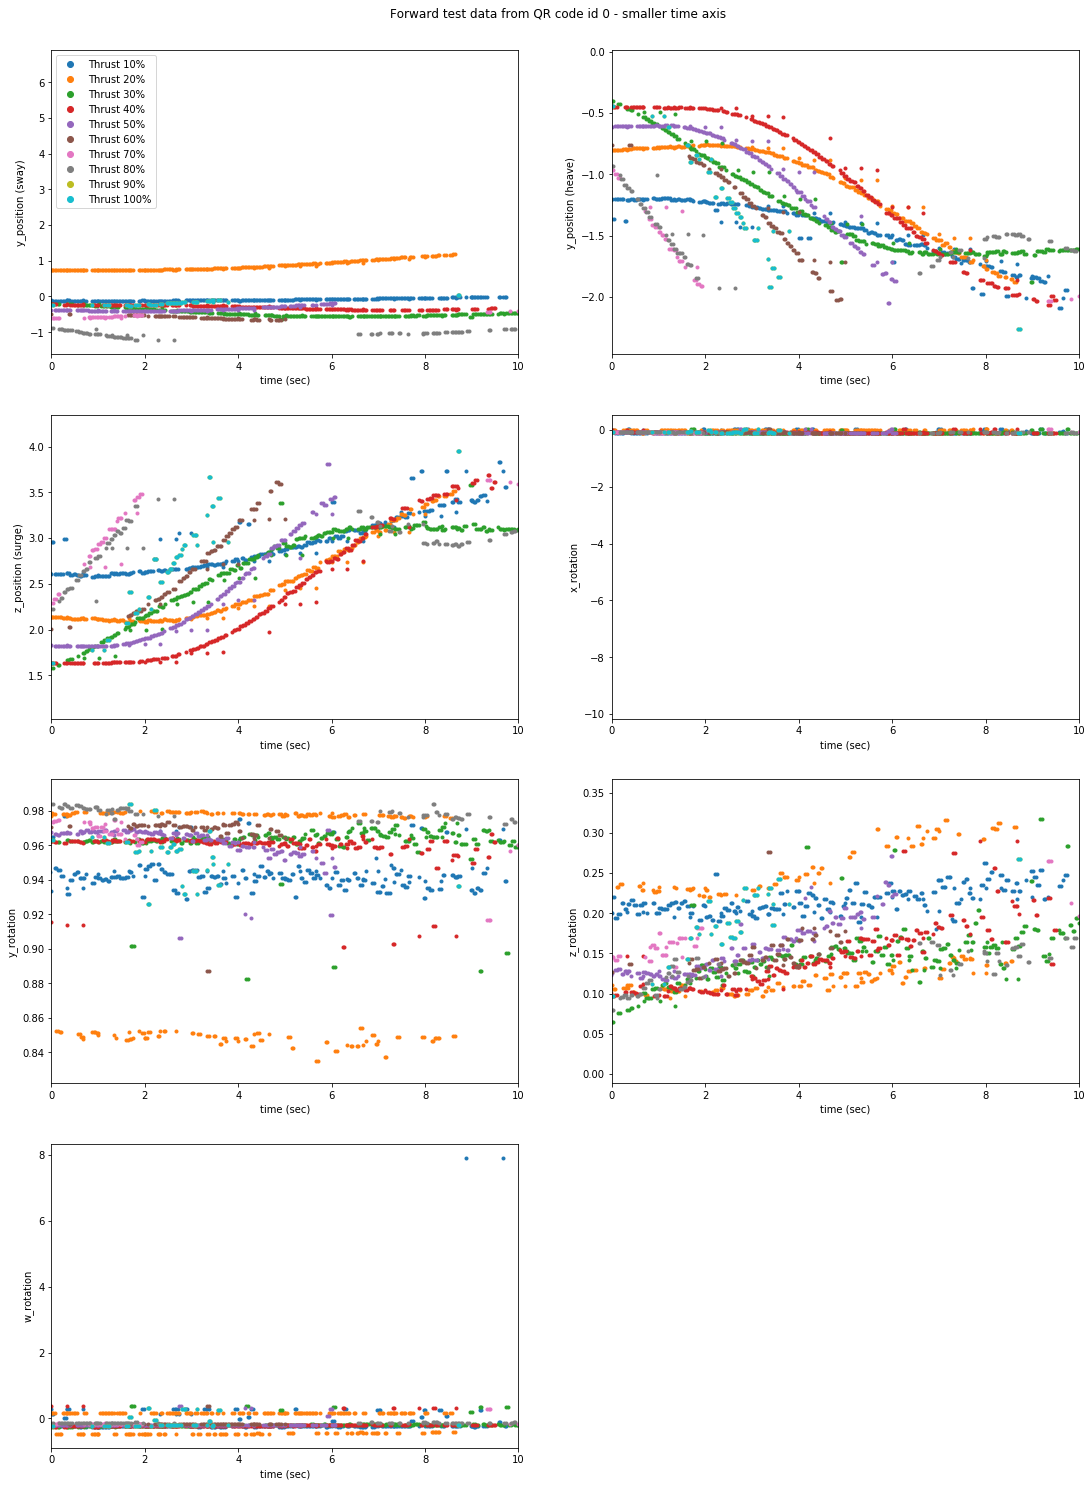

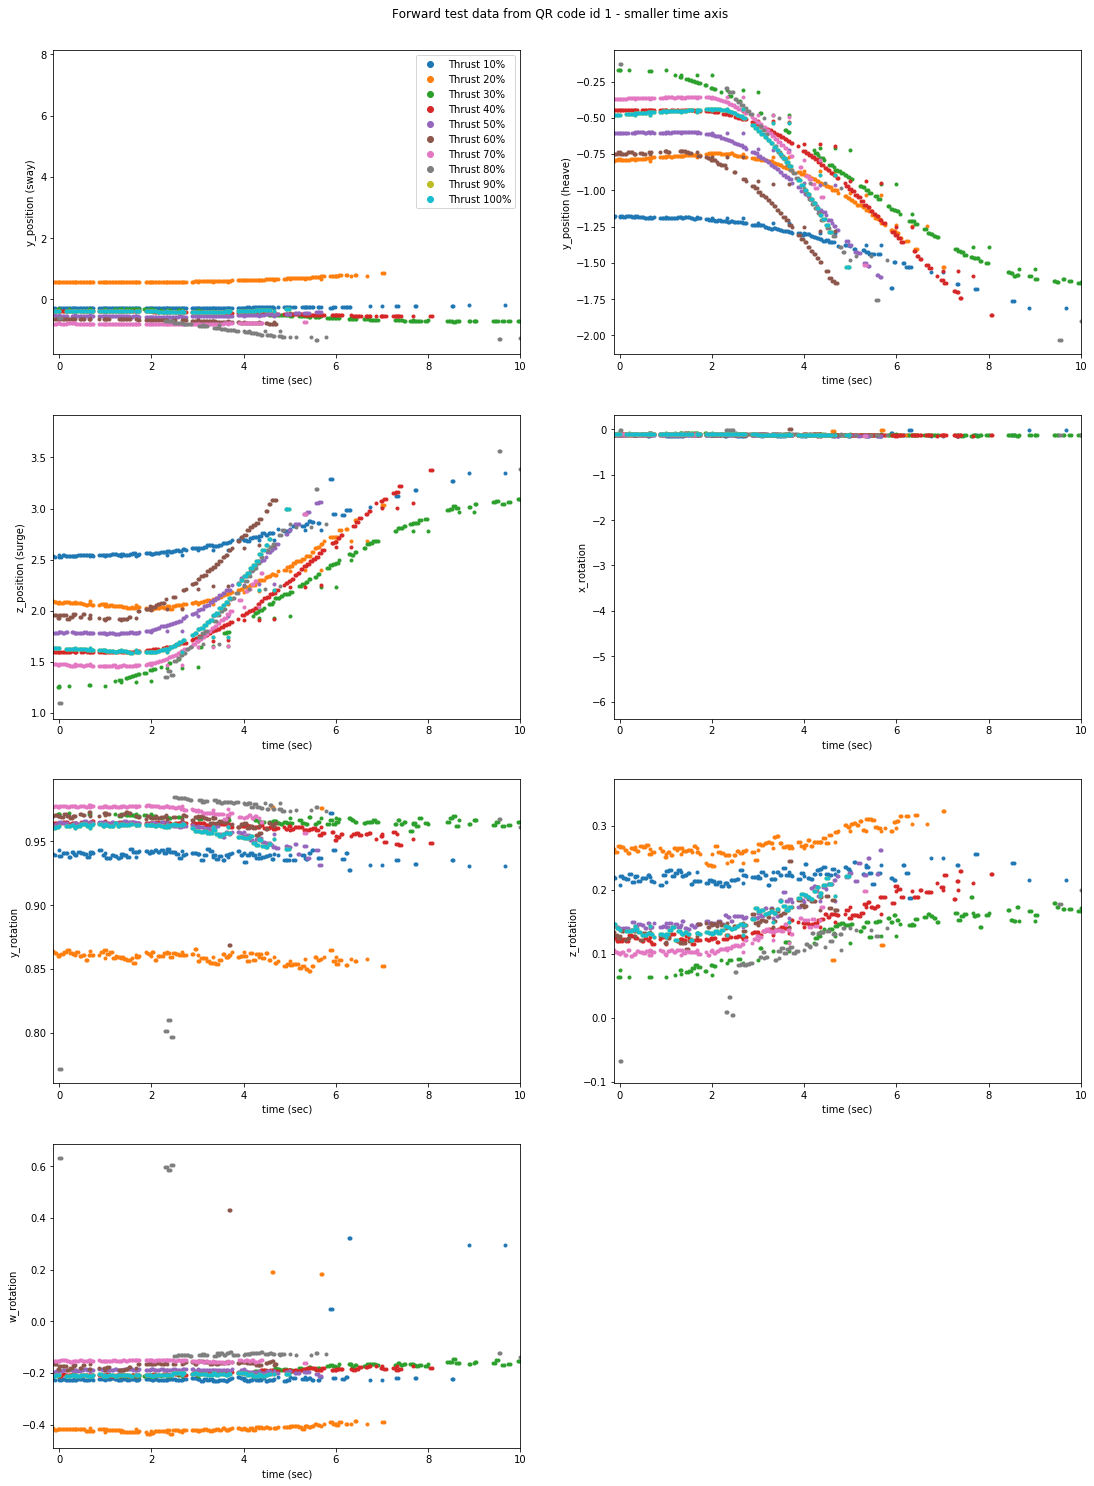

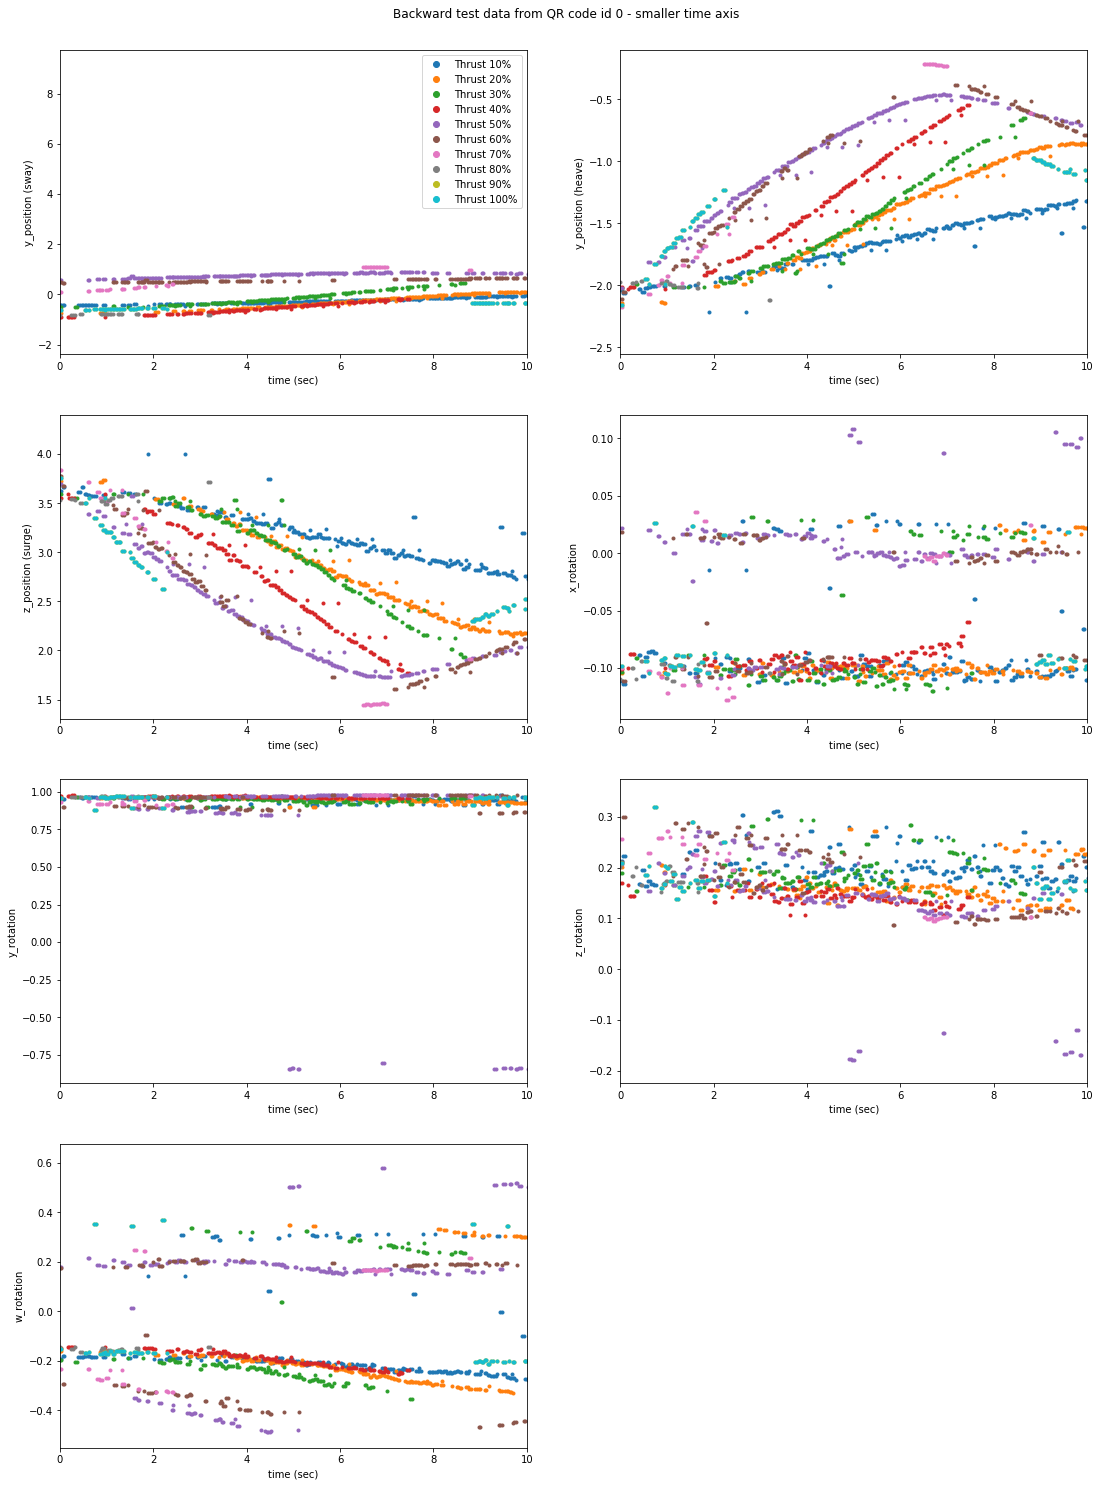

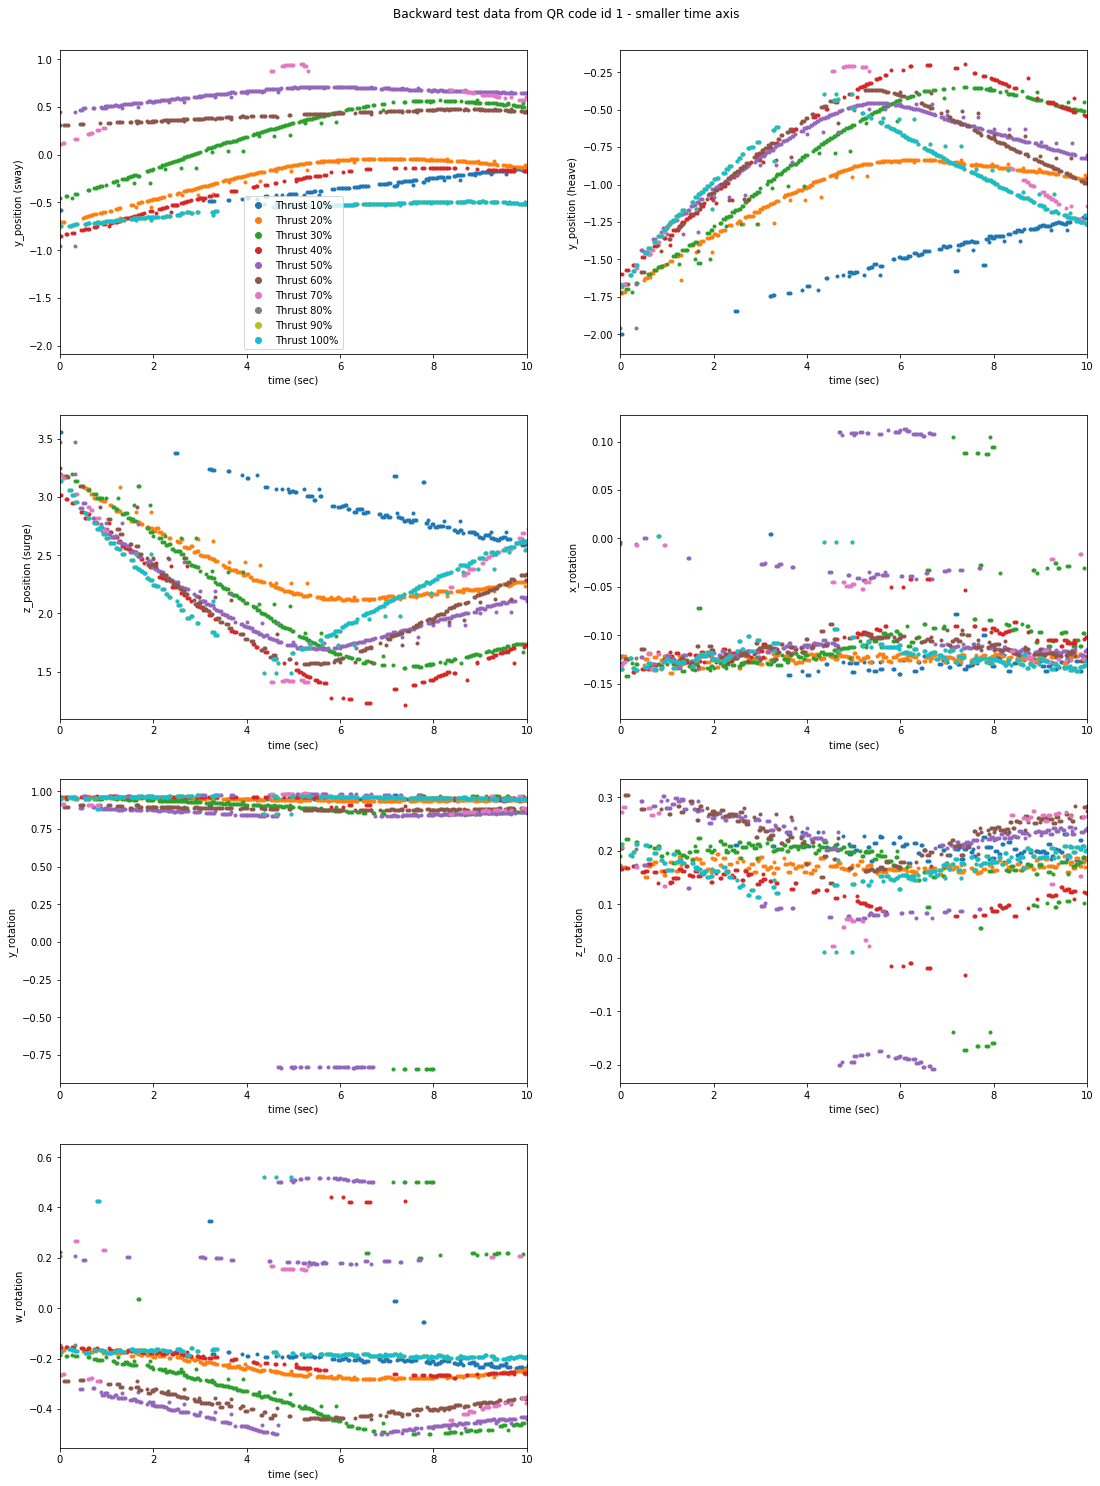

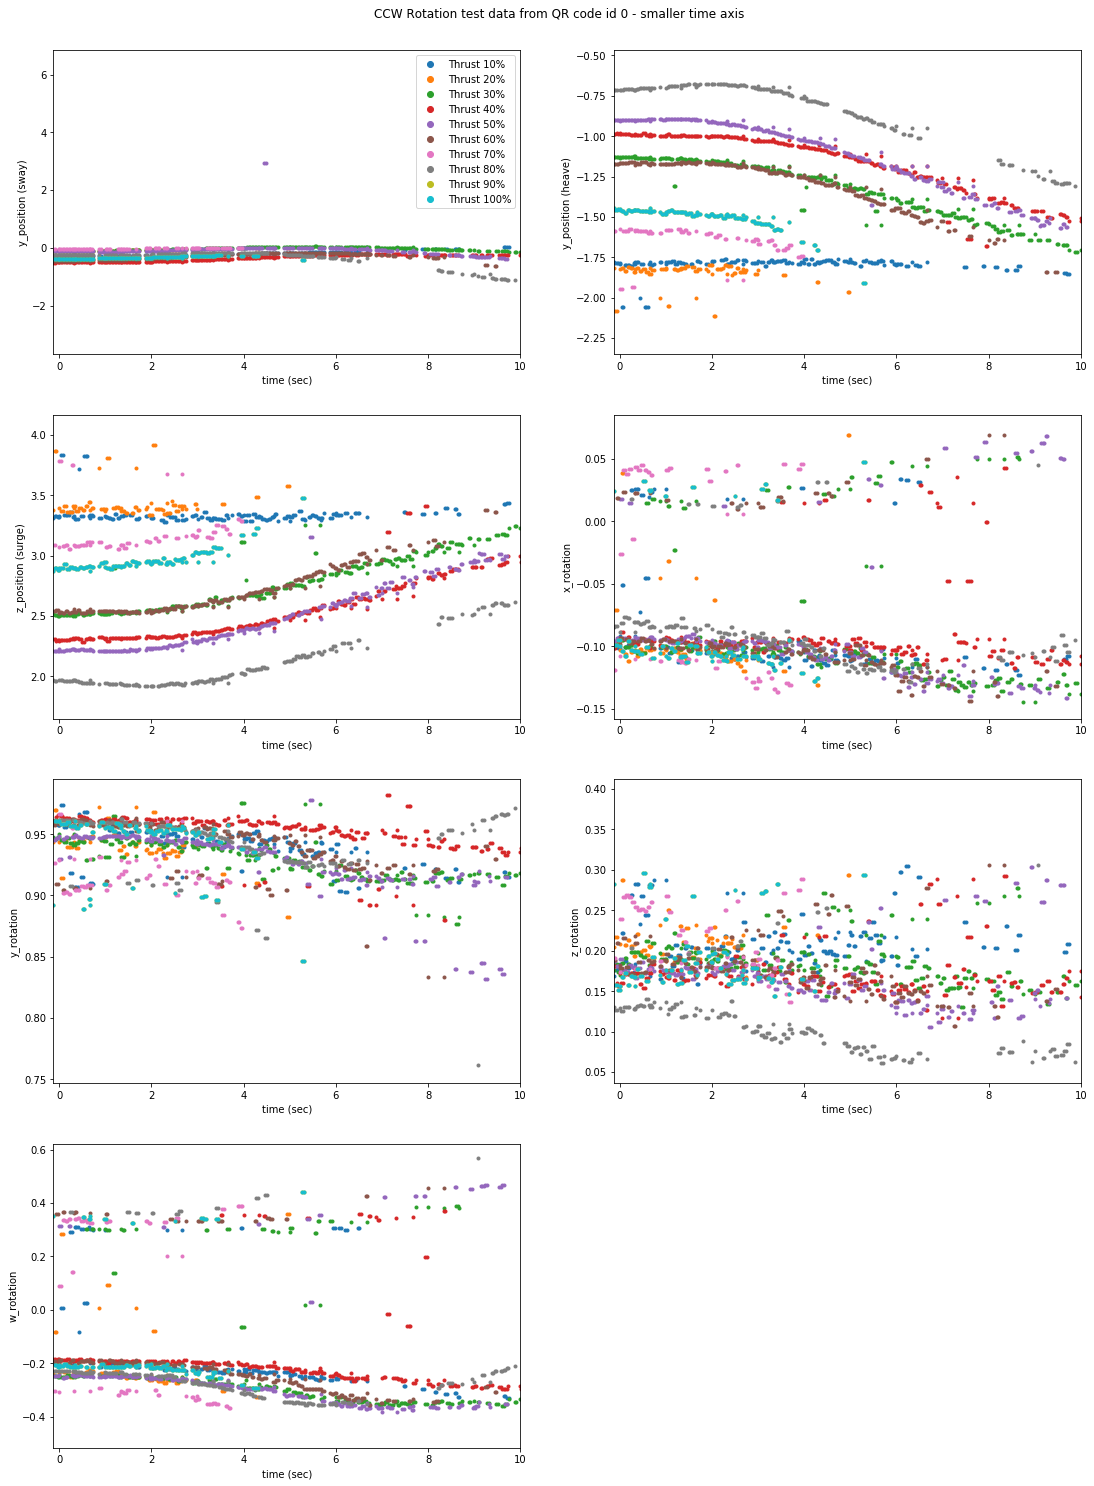

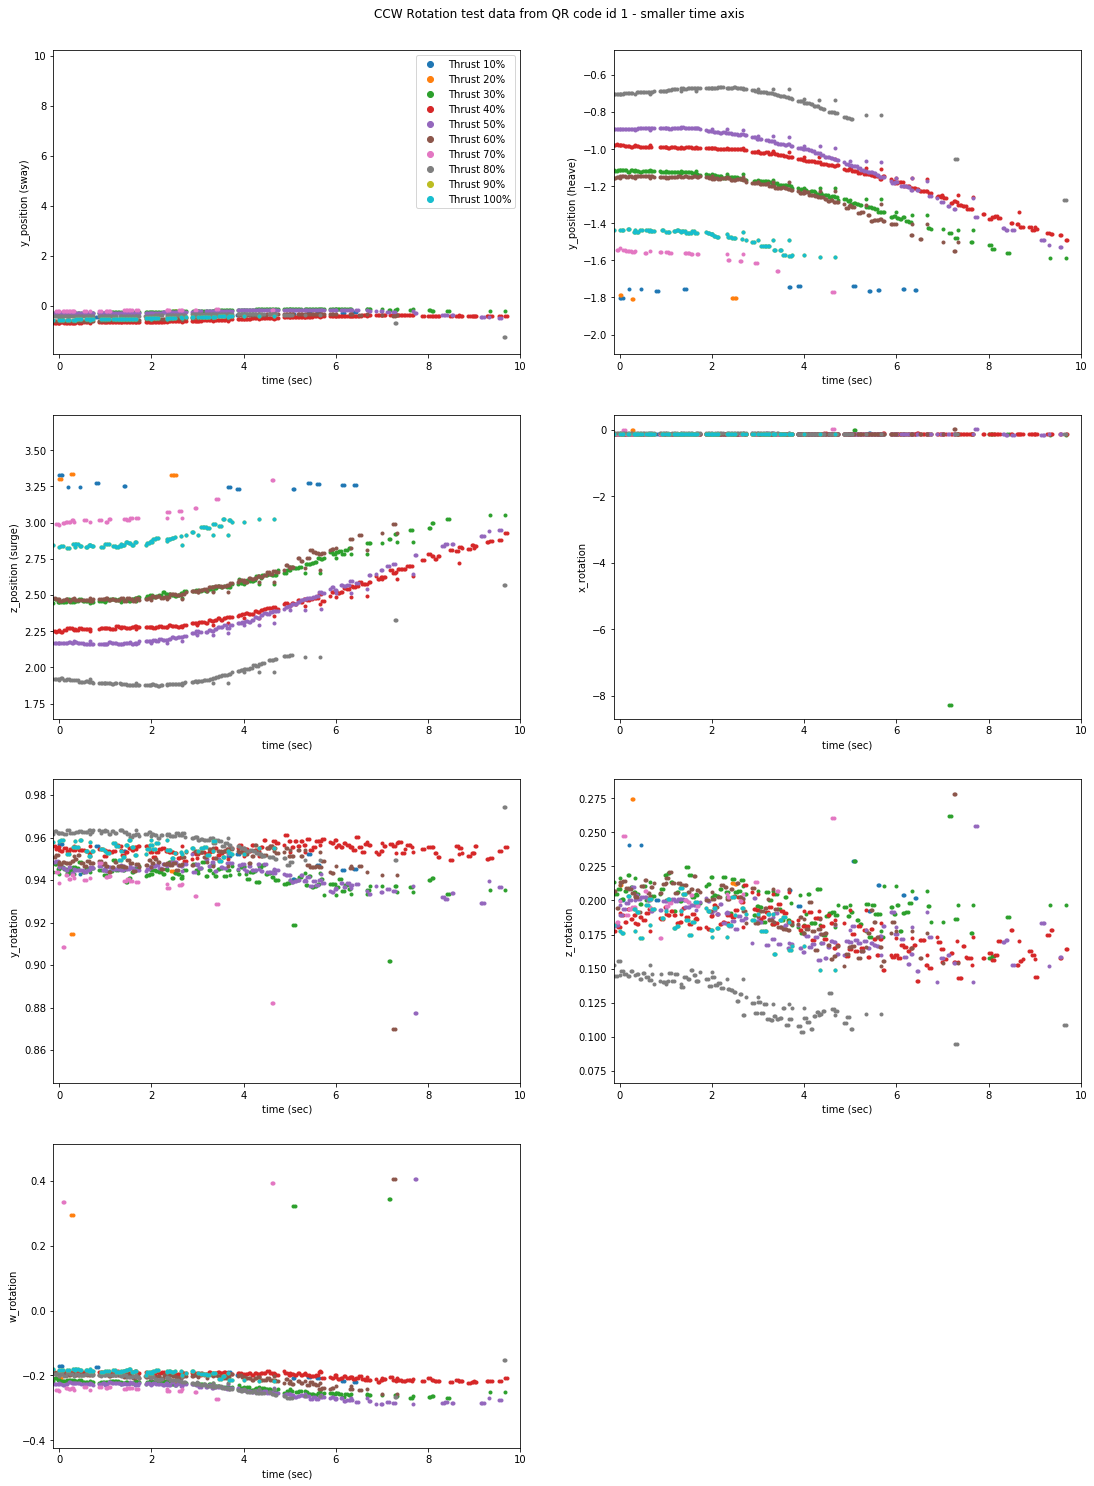

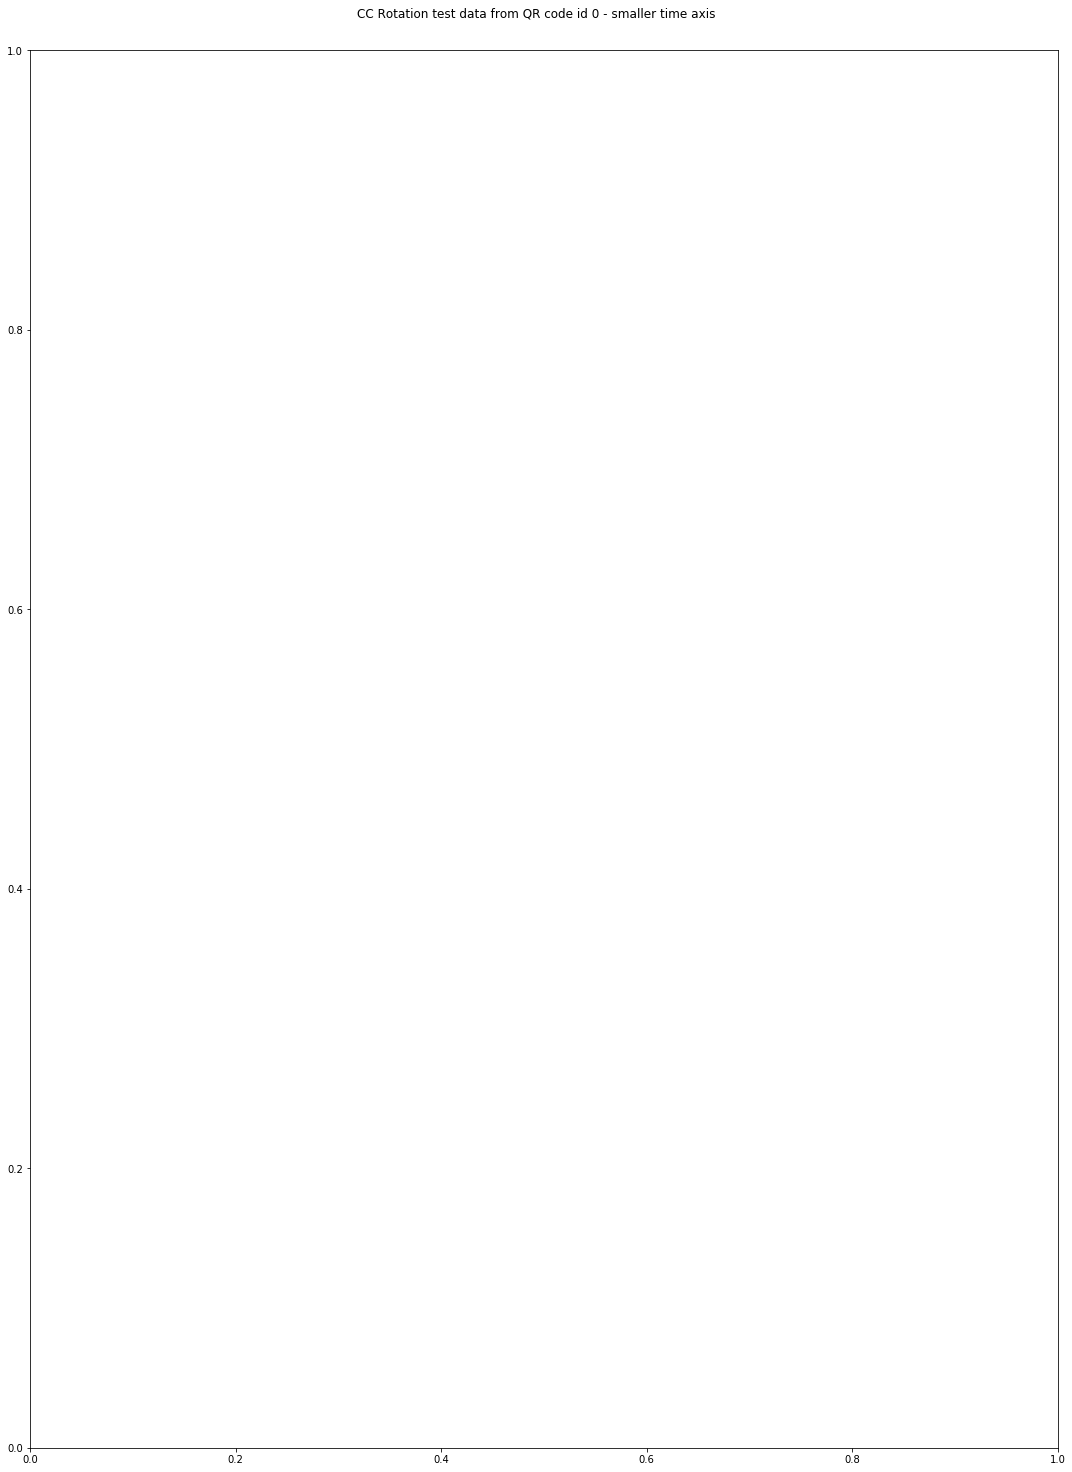

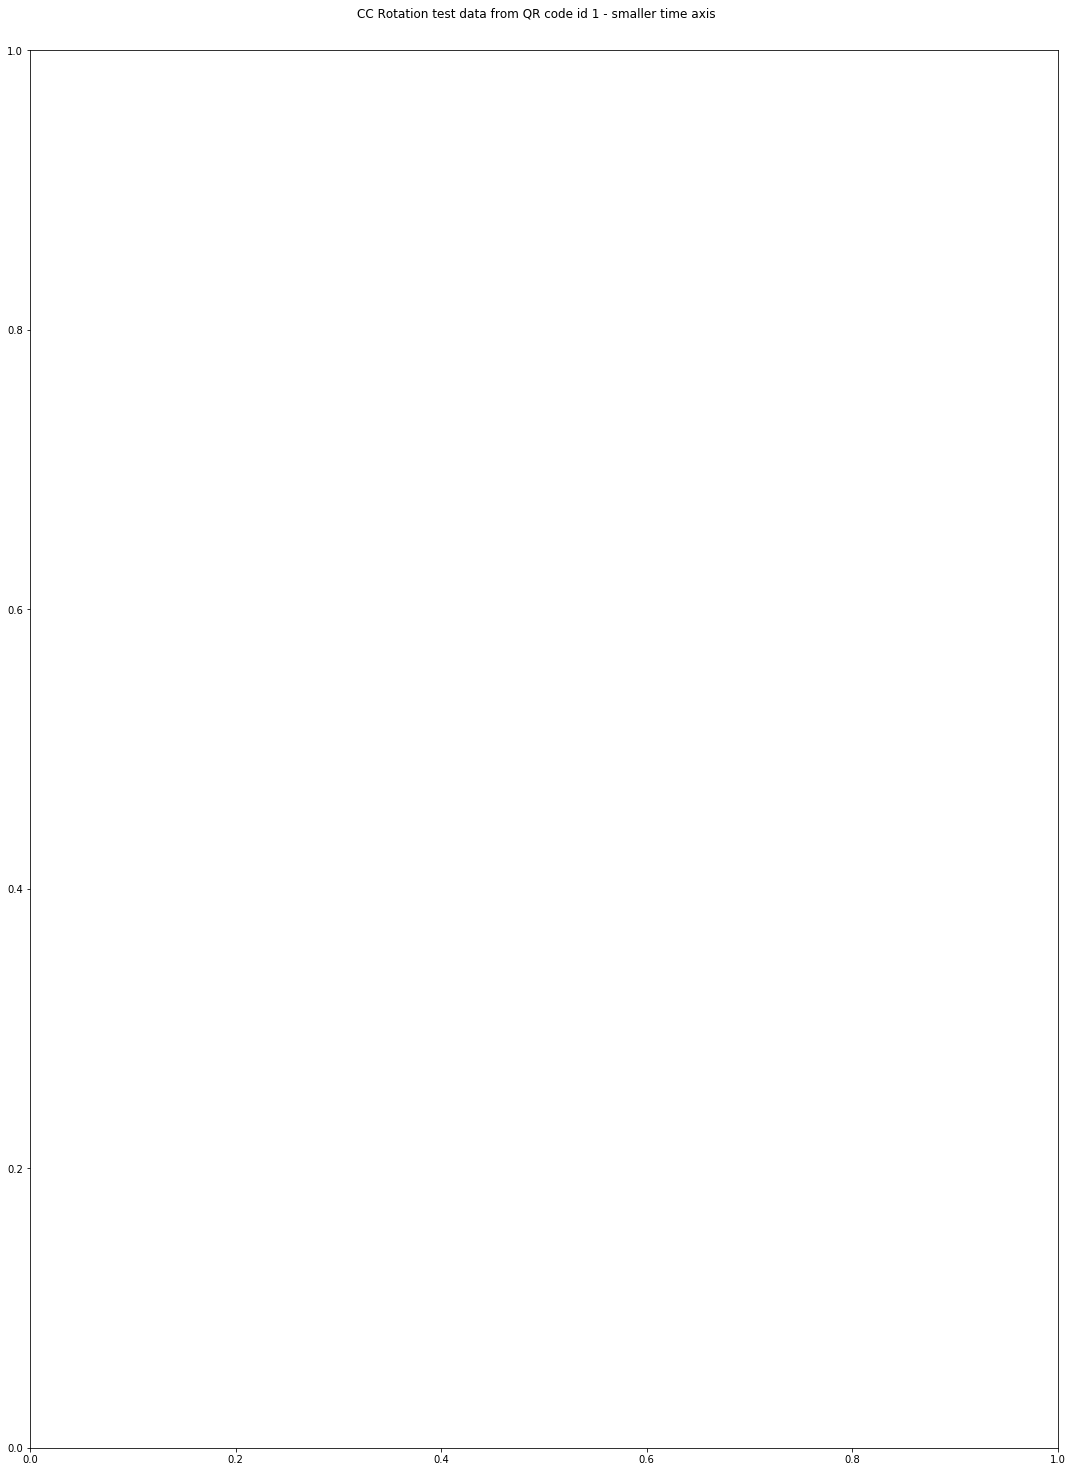

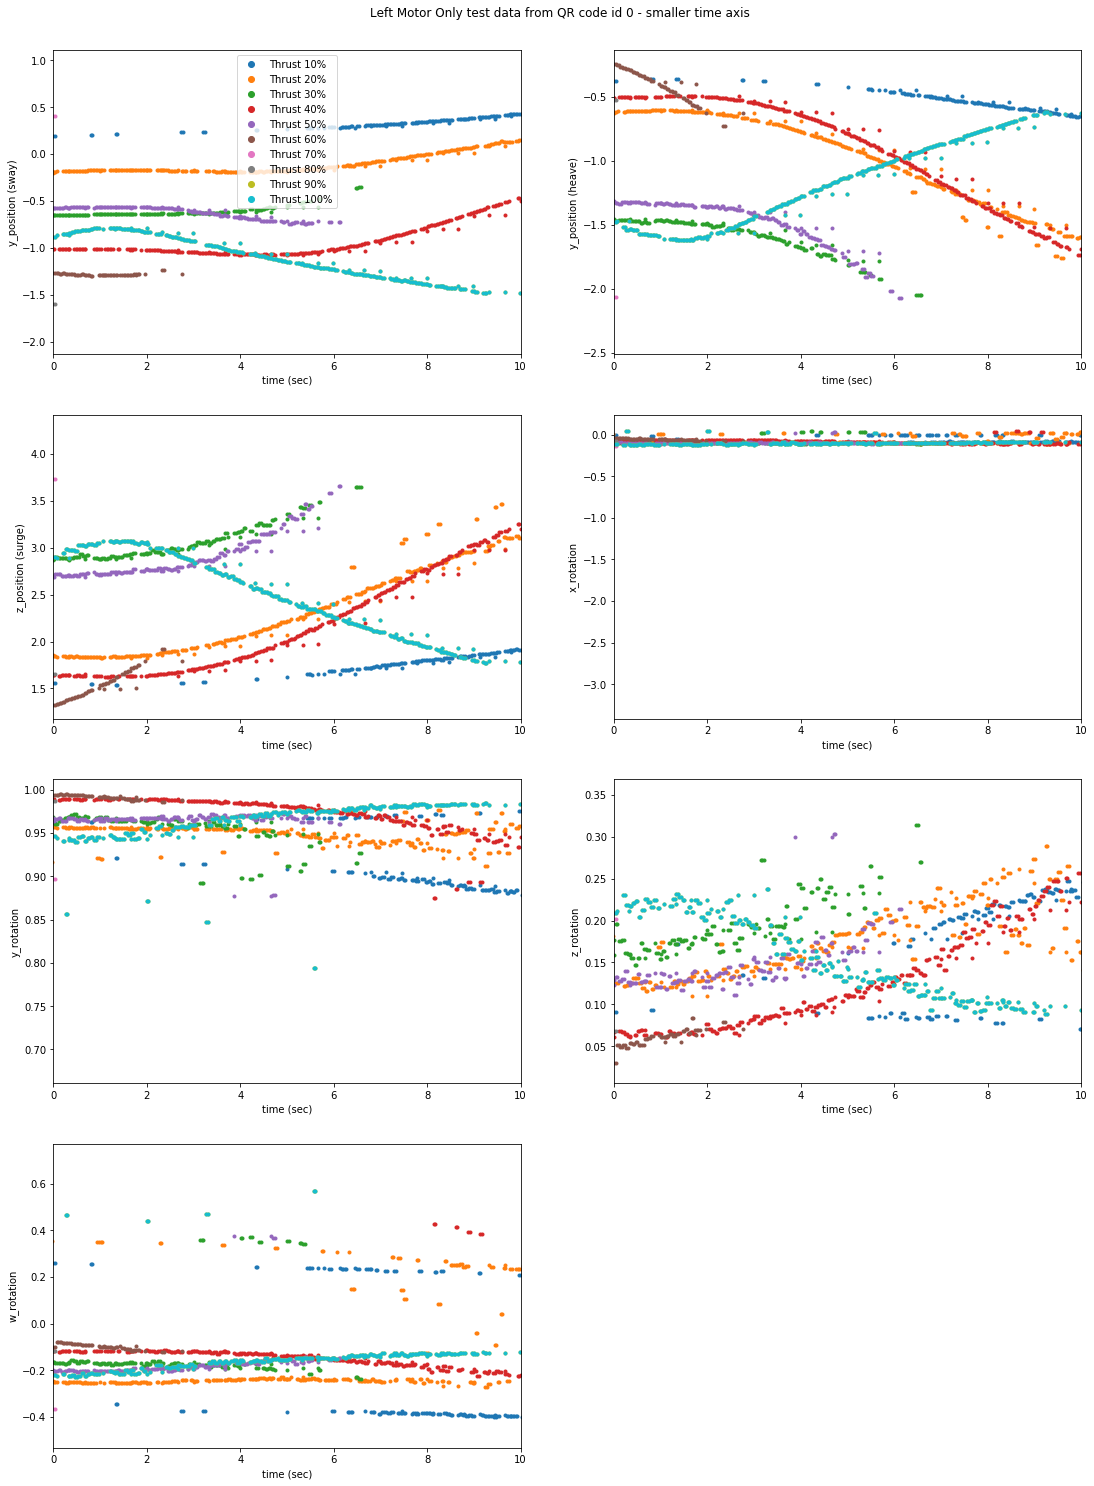

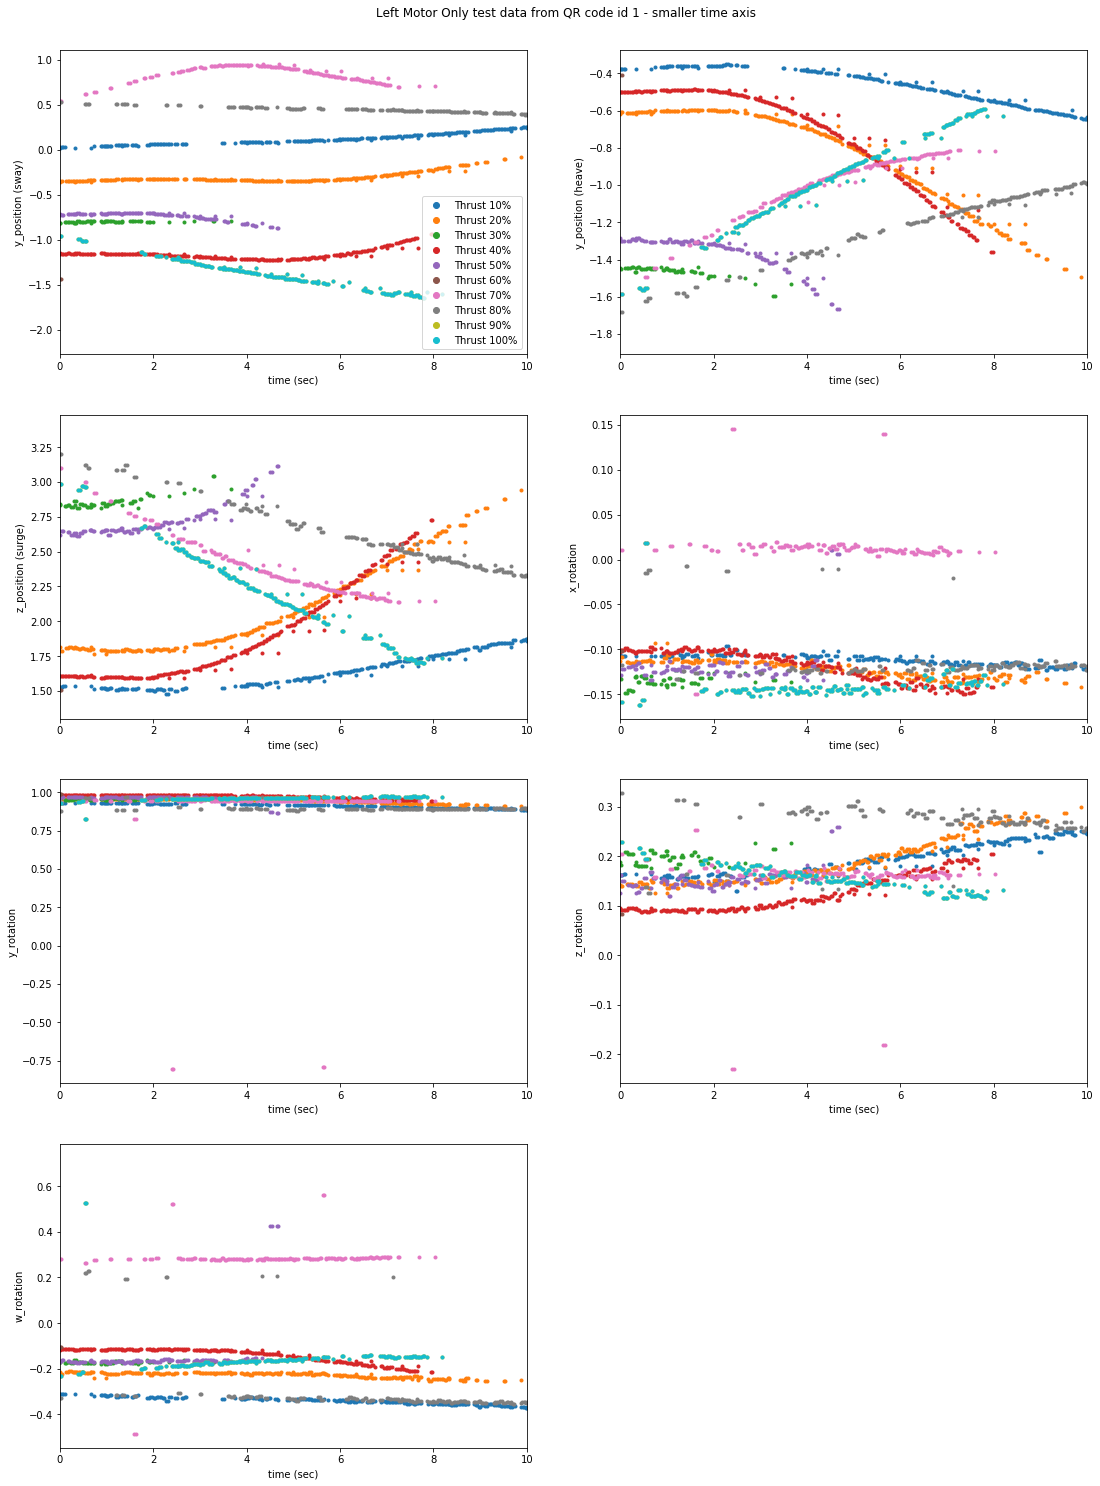

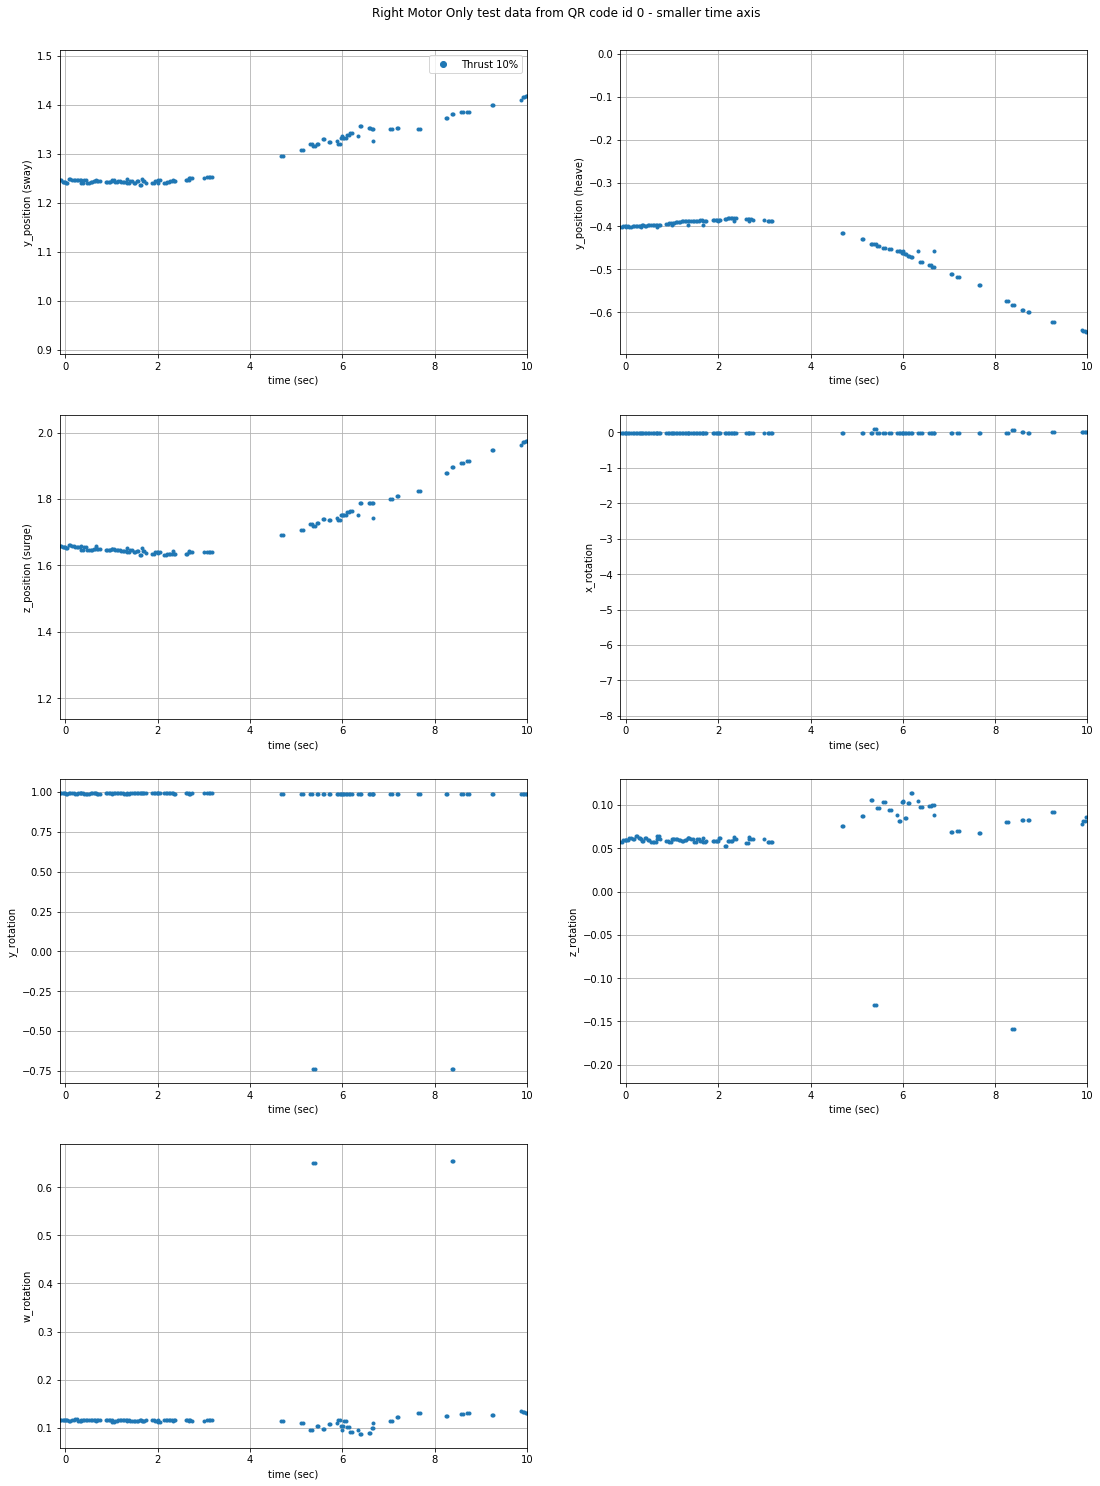

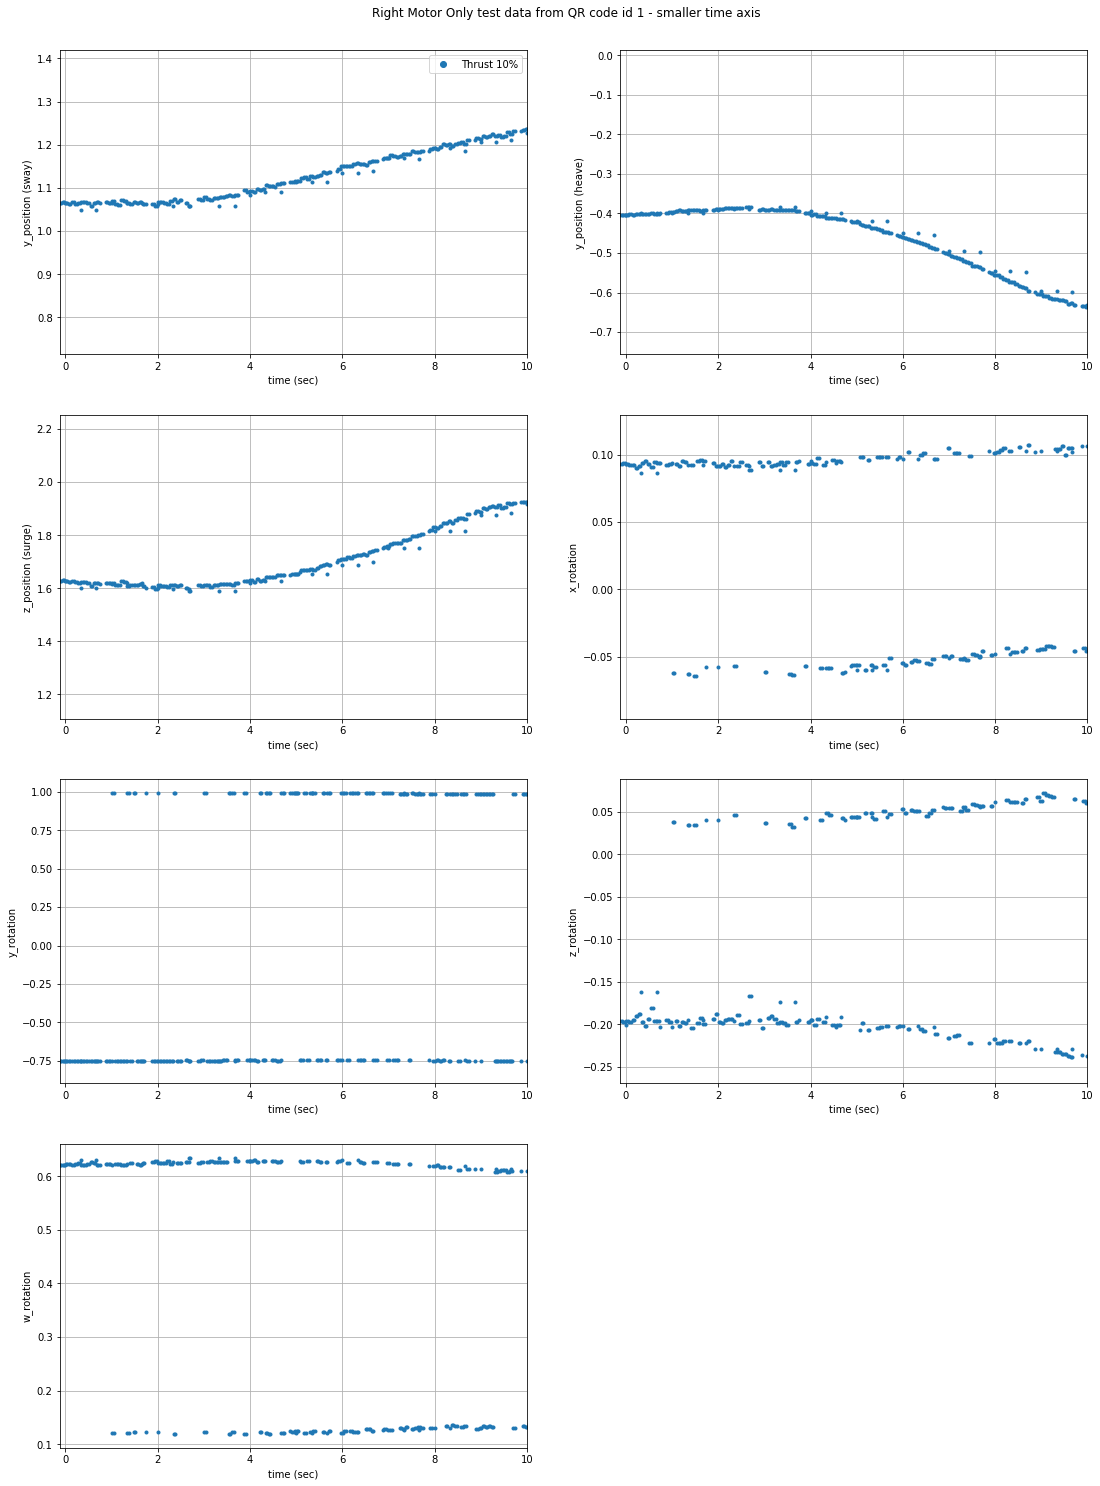

In [114]:
test_types = ['Forward', 'Backward', 'CCW Rotation', 'CC Rotation', 'Left Motor Only', 'Right Motor Only']
QR_code_ids = [0, 1]

for test_type in test_types:
    for QR_code_id in QR_code_ids:
        try:
            plot_state_over_time(test_type, QR_code_id)
        except:
            pass